## Preprocessing

In [3]:
#  Import charity_data.csv.
# https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92 
from google.colab import files
uploaded = files.upload()

Saving charity_data.csv to charity_data.csv


In [31]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 6.1 MB/s 


In [32]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

#  Read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [6]:
# Check for null values
application_df.isnull().sum()

EIN                       0
NAME                      0
APPLICATION_TYPE          0
AFFILIATION               0
CLASSIFICATION            0
USE_CASE                  0
ORGANIZATION              0
STATUS                    0
INCOME_AMT                0
SPECIAL_CONSIDERATIONS    0
ASK_AMT                   0
IS_SUCCESSFUL             0
dtype: int64

In [7]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(['EIN', 'NAME'], axis = 1, inplace = True)
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [8]:
# Number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [9]:
# APPLICATION_TYPE value counts for binning
app_count = application_df['APPLICATION_TYPE'].value_counts()
app_count

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [10]:
# Check app types with less than 528 applications
list(app_count[app_count < 528].index)

['T9', 'T13', 'T12', 'T2', 'T14', 'T25', 'T29', 'T15', 'T17']

In [11]:
# Cutoff point = 528 to bin "rare" categorical variables together in a new value, Other.
application_types_to_replace = list(app_count[app_count < 528].index)

# Replace with Other in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Verify binning.
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [12]:
# CLASSIFICATION value counts for binning
classification_count = application_df['CLASSIFICATION'].value_counts()
classification_count

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C1570        1
C4120        1
C1283        1
C1732        1
C4200        1
Name: CLASSIFICATION, Length: 71, dtype: int64

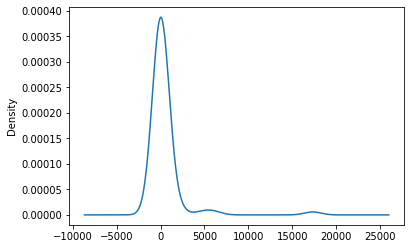

In [13]:
classification_count.plot.density()

In [14]:
# Cutoff point = 900 to bin "rare" categorical variables together in a new value, Other.
classifications_to_replace = list(classification_count[classification_count < 900].index)

# Replace with Other in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Verify binning
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [15]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_app_df = pd.get_dummies(application_df)
numeric_app_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,108590,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,5000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1,6692,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
4,1,142590,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [34]:
numeric_app_df.shape

(34299, 44)

##### **Target variable** = IS_SUCCESSFUL
##### **Features** = ASK_AMT, APPLICATION_TYPE, AFFILIATION, CLASSIFICATION,USE_CASE, ORGANIZATION, STATUS, INCOME_AMT, SPECIAL_CONSIDERATIONS

In [16]:
# Split our preprocessed data into our features and target arrays
y = numeric_app_df['IS_SUCCESSFUL']
X = numeric_app_df.drop(['IS_SUCCESSFUL'], axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# Create StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

In [44]:
number_input_features = len(X_train_scaled[0])

In [45]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=5), activation=activation, input_dim=number_input_features))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))
    
    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn

### Import Keras Tuner Library for Optimizing Model

In [47]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    project_name='charity_optimization')

In [48]:
# Stop early, aiming for 75% accuracy
# patience = number of epochs with no improvement after which training will be stopped.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [49]:
# Run the kerastuner search for best hyperparameters
# Run with caution - this takes 16 minutes to run
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('first_units')}, the number of layers are {best_hps.get('num_layers')} the optimal activation function for the optimizer
is {best_hps.get('activation')}.
""")

Trial 60 Complete [00h 00m 44s]
val_accuracy: 0.7280466556549072

Best val_accuracy So Far: 0.7332944869995117
Total elapsed time: 00h 16m 42s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 21, the number of layers are 2 the optimal activation function for the optimizer
is tanh.



In [43]:
# The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly 
# converge on a high-performing model. This is done using a sports championship style bracket. 
# The algorithm trains a large number of models for a few epochs and carries forward only the top-performing 
# half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 
# 1 + logfactor(max_epochs) and rounding it up to the nearest integer.

With a value accuracy of  model could be further optimized, however loss value of 55 implies that 
the model could be further optimized. The accuracy value shows that 73% of the model's predicted values align with the true values in the original dataset.  

In [ ]:
# Export our model to HDF5 file
nn.save('Models/AlphabetSoupCharity.h5')